In [1]:
from scripts.utils import rectify_homography, display_images

import os
import glob
import cv2
import numpy as np
from skimage.io import imread

# Automatische Registrierung zweier Bilder mit SIFT und RANSAC
## Direkte Lineartransformation

### Teil A
Implementieren Sie die direkte Linear transformation zur Schätzung einer Homografie zwischen zwei Bildern eines Panoramas. Normieren Sie Ihre Homografie immer so, dass der letzte untere Eintrag in der Homografie-Matrix 1 ist.

In [2]:
def dlt(origin_points, dest_points):

    V = []

    for i in range(len(origin_points)):
        x_origin, y_origin = origin_points[i]
        x_dest, y_dest = dest_points[i]

        V.append([x_origin, y_origin, 1, 0, 0, 0, -x_dest * x_origin, -x_dest * y_origin, -x_dest])
        V.append([0, 0, 0, x_origin, y_origin, 1, -y_dest * x_origin, -y_dest * y_origin, -y_dest])


    U, S, Vt = np.linalg.svd(np.array(V))
    H = Vt[-1].reshape(3, 3)
    return H / H[2, 2]

### Teil B
Wählen Sie aus einem überlappenden Bildpaar (am Besten aus Übung 3) mindestens 6 Korrespondenzpunkte per Hand aus, d.h. bestimmen Sie wie in Übung 3 die Pixelposition der korrespondierenden Punkte in beiden Bildern. Nehmen Sie 4 Korrespondenzen zur Schätzung der Homografie per DLT und testen Sie anhand der anderen Korrespondenzen die Korrektheit Ihrer Homografie, indem Sie mithilfe der Homografie die Bildposition des Punktes im neuen Bild berechnen und dann den mittleren euklidischen Abstand zu dem korrespondierenden Punkt bestimmen (diese Routine wird später noch für RANSAC gebraucht).

In [3]:
def calculate_error(H, img_1, img_2):
    distances = []

    for i, point in enumerate(img_1[4:]):

        x1, y1 = point
        x2_actual, y2_actual = img_2[4 + i]

        transformed = H @ np.array([x1, y1, 1])
        x2_pred, y2_pred = transformed[0] / transformed[2], transformed[1] / transformed[2]

        distance = np.sqrt((x2_pred - x2_actual)**2 + (y2_pred - y2_actual)**2)
        distances.append(distance)
        print(f"Point {i+1}: predicted ({x2_pred:.1f}, {y2_pred:.1f}), actual ({x2_actual}, {y2_actual}), distance: {distance:.2f}")

    mean_error = np.mean(distances)
    print(f"Mean euclidean distance: {mean_error:.2f} pixels")

In [4]:
bib_1 = np.array([[700, 583], [1265, 599], [1271, 715], [691, 695], [842, 605], [1114, 608]])
bib_2 = np.array([[56, 522], [583, 517], [587, 623], [47, 628], [196, 538], [450, 533]])

In [5]:
H = dlt(bib_1[:4], bib_2[:4])
calculate_error(H, bib_1, bib_2)

Point 1: predicted (191.3, 537.6), actual (196, 538), distance: 4.73
Point 2: predicted (445.0, 530.6), actual (450, 533), distance: 5.52
Mean euclidean distance: 5.13 pixels


### Teil C
Aufbauend auf Übung 1, schreiben Sie eine Routine zur indirekten Umbildung eines Bildes mithilfe einer Homografie und testen Sie sie anhand der geschätzten Homografie aus *Aufgabe 1 b*. Schreiben Sie ein Programm zur Registrierung zweier Bilder.

In [6]:
data_dir = 'data/stiching'
image_paths = sorted(glob.glob(os.path.join(data_dir, 'bib_*.jpeg')))
images = []

for image_path in image_paths:
    images.append(imread(image_path))

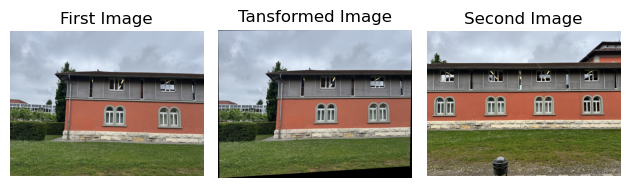

In [7]:
H, height, width = rectify_homography(H, images[0])
warped_img_dlt = cv2.warpPerspective(images[0], H, (width, height))

display_images(
    [images[0], warped_img_dlt, images[1]],
    ["First Image", "Tansformed Image", "Second Image"]
)

### Teil D
Implementieren Sie nun die normierte DLT wie in Vorlesung 5 beschrieben. Wiederholen Sie alle vorigen Tests für die normierte DLT.

In [8]:
def normalize_points(points):
    centroid = np.mean(points, axis=0)
    centered = points - centroid

    avg_squared_dist = np.mean(np.sum(centered**2, axis=1))
    scale = 1.0 / np.sqrt(avg_squared_dist) if avg_squared_dist > 0 else 1.0

    normalized = centered * scale

    T = np.array([[scale, 0, -scale * centroid[0]],
                  [0, scale, -scale * centroid[1]],
                  [0, 0, 1]])

    return normalized, T

def denormalize(H_normalized, T1, T2):
    H = np.linalg.inv(T2) @ H_normalized @ T1
    return H / H[2, 2]

Point 1: predicted (191.3, 537.6), actual (196, 538), distance: 4.73
Point 2: predicted (445.0, 530.6), actual (450, 533), distance: 5.52
Mean euclidean distance: 5.13 pixels


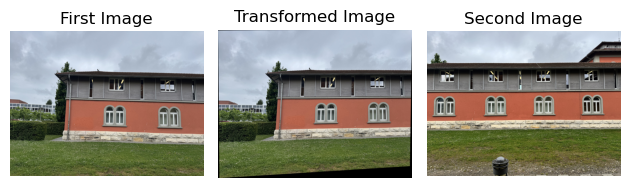

In [9]:
bib_1_normalized, T1 = normalize_points(bib_1)
bib_2_normalized, T2 = normalize_points(bib_2)

H_normalized = dlt(bib_1_normalized[:4], bib_2_normalized[:4])

H = denormalize(H_normalized, T1, T2)

calculate_error(H, bib_1, bib_2)

H_rect, height, width = rectify_homography(H, images[0])
warped_img_dlt = cv2.warpPerspective(images[0], H_rect, (width, height))

display_images(
    [images[0], warped_img_dlt, images[1]],
    ["First Image", "Transformed Image", "Second Image"]
)

## RANSAC
### Teil A
Implementieren Sie den RANSAC-Algorithmus für die normierte DLT. Dazu wählt der Algorithmus aus einem Satz von Korrespondenzen zufällig eine Vierergruppe aus, berechnet die Homografie mithilfe der normierten DLT und berechnet den mittleren euklidischen Abstand der übrigen Korrespondenzen.

In [10]:
def ransac(points1, points2, max_inlier_distance=5.0, num_iterations=1000, min_consensus_size=4):
    best_homography = None
    best_inliers = []
    max_inlier_count = 0

    for iteration in range(num_iterations):
        random_indices = np.random.choice(len(points1), 4, replace=False)
        sample_points1 = points1[random_indices]
        sample_points2 = points2[random_indices]

        points1_norm, T1 = normalize_points(sample_points1)
        points2_norm, T2 = normalize_points(sample_points2)

        H_normalized = dlt(points1_norm, points2_norm)
        H = denormalize(H_normalized, T1, T2)

        inliers = []
        distances = []

        for i in range(len(points1)):

            x1, y1 = points1[i]
            x2_actual, y2_actual = points2[i]

            transformed = H @ np.array([x1, y1, 1])
            x2_pred, y2_pred = transformed[0] / transformed[2], transformed[1] / transformed[2]

            distance = np.sqrt((x2_pred - x2_actual)**2 + (y2_pred - y2_actual)**2)
            distances.append(distance)

            if distance < max_inlier_distance:
                inliers.append(i)

        if len(inliers) >= min_consensus_size and len(inliers) > max_inlier_count:
            max_inlier_count = len(inliers)
            best_homography = H
            best_inliers = inliers

    return best_homography, best_inliers

### Teil B
Ergänzen Sie Ihre Trainingsdaten aus Aufgabe 1 um mehrere Fehlkorrespondenzen und testen Sie Ihre Implementierung von RANSAC. Kommt die korrekte Homografie heraus?
Wurde ein korrektes Consensus set gefunden?

In [11]:
height1, width1 = images[0].shape[:2]
height2, width2 = images[1].shape[:2]

bib_1_with_error = np.vstack([
    bib_1,
    [np.random.randint(0, width1), np.random.randint(0, height1)],
    [np.random.randint(0, width1), np.random.randint(0, height1)]
])

bib_2_with_error = np.vstack([
    bib_2,
    [np.random.randint(0, width2), np.random.randint(0, height2)],
    [np.random.randint(0, width2), np.random.randint(0, height2)]
])

In [12]:
def ransac_stats(H_ransac, inliers, bib_1_with_error, bib_2_with_error):
    print(f"RANSAC found {len(inliers)} inliers out of {len(bib_1_with_error)} points")

    distances = []
    for i in range(len(bib_1_with_error)):
        x1, y1 = bib_1_with_error[i]
        x2_actual, y2_actual = bib_2_with_error[i]

        point_homo = np.array([x1, y1, 1])
        transformed = H_ransac @ point_homo
        x2_pred, y2_pred = transformed[0] / transformed[2], transformed[1] / transformed[2]

        distance = np.sqrt((x2_pred - x2_actual)**2 + (y2_pred - y2_actual)**2)
        distances.append(distance)

        status = "INLIER" if i in inliers else "OUTLIER"
        print(f"Point {i}: distance = {distance:.2f} px ({status})")

    mean_error_inliers = np.mean([distances[i] for i in inliers])
    print(f"\nMean error for inliers: {mean_error_inliers:.2f} px")

RANSAC found 6 inliers out of 8 points
Point 0: distance = 0.70 px (INLIER)
Point 1: distance = 4.00 px (INLIER)
Point 2: distance = 0.00 px (INLIER)
Point 3: distance = 0.00 px (INLIER)
Point 4: distance = 0.00 px (INLIER)
Point 5: distance = 0.00 px (INLIER)
Point 6: distance = 833.81 px (OUTLIER)
Point 7: distance = 1101.15 px (OUTLIER)

Mean error for inliers: 0.78 px


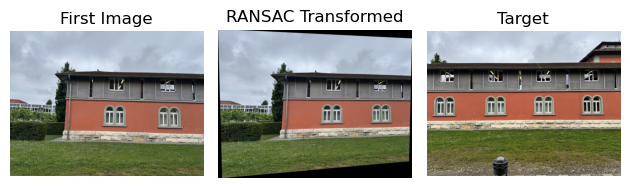

In [13]:
H_ransac, inliers = ransac(bib_1_with_error, bib_2_with_error, max_inlier_distance=5.0, num_iterations=100)
ransac_stats(H_ransac, inliers, bib_1_with_error, bib_2_with_error)

H_rect, height, width = rectify_homography(H_ransac, images[0])
warped_img_ransac = cv2.warpPerspective(images[0], H_rect, (width, height))

display_images([images[0], warped_img_ransac, images[1]],
               ["First Image", "RANSAC Transformed", "Target"]
               )

## Automatisertes Matching mit RANSAC
### Teil A
Falls noch nicht geschehen, installieren Sie OpenCV. Laden Sie das auf der Vorlesungsseite zur Verfügung gestellte Modul sift.py und installieren Sie es im selben Verzeichnis, in dem auch Ihr Code liegt. Konvertieren Sie Ihre Bilder in Grauwertbilder mit `cv2.cvtColor(im1,cv2.COLOR_BGR2GRAY)`.
Das Extrahieren der interest points und der Deskriptoren geschieht durch folgenden Code:
```python
import cv2 ,sift

# .. Bild einlesen und konvertieren
img = cv2.cvtColor (img, cv2.COLOR_BGR2GRAY)
location_list , descriptor_list = sift.detect_and_compute(img)
```

Das Matching, d.h. das Auﬃnden korrespondierender Punkte mit ähnlichem SIFT-Deskriptor und Darstellung geschieht über:

```python
matches = sift.match_twosided(descriptor_list_img1, descriptor_list_img2)
sift.plot_matches(im1, im2, location_list_img1, location_list_img2, matches, True)
```

Testen Sie Ihren Code an dem Bildpaar aus Aufgabe 1 und 2. Wenn die Berechnung von SIFT und Matching korrekt funktioniert, können Sie nun automatisch eine Liste von Korrespondenzen erstellen.

5045 key points detected.
5518 key points detected.


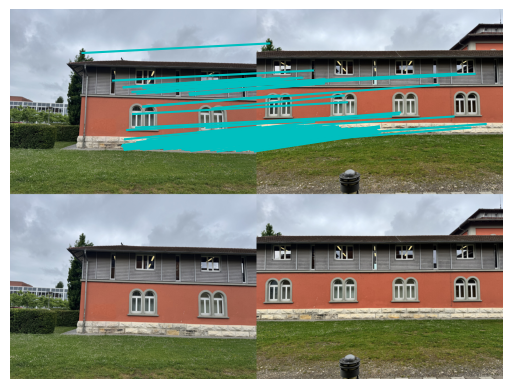

In [14]:
import scripts.sift as sift

img1_grey = cv2.cvtColor(images[0], cv2.COLOR_BGR2GRAY)
img1_location_list, img1_descriptor_list = sift.detect_and_compute(img1_grey)

img2_grey = cv2.cvtColor(images[1], cv2.COLOR_BGR2GRAY)
img2_location_list, img2_descriptor_list = sift.detect_and_compute(img2_grey)

matches = sift.match_twosided(img1_descriptor_list, img2_descriptor_list)
sift.plot_matches(images[0], images[1], img1_location_list, img2_location_list, matches, True)

### Teil B
Testen Sie Ihre automatisch gefundenen Korrespondenzen mit RANSAC (500–1000 Iterationen) und normierter DLT. Kommt die gleiche oder zumindest eine ähnliche Homographie heraus? Welchen mittleren quadratischen Fehler erhalten Sie? Erstellen Sie ein Programm
 zur automatischen Registrierung zweier Bilder und testen Sie dieses an allen Bildpaaren aus Übungsblatt 3.

/var/folders/jp/g933n74j7yn5xk_r1klnq9xr0000gn/T/ipykernel_16264/2610194037.py:26: RuntimeWarning: divide by zero encountered in scalar divide
  x2_pred, y2_pred = transformed[0] / transformed[2], transformed[1] / transformed[2]
/var/folders/jp/g933n74j7yn5xk_r1klnq9xr0000gn/T/ipykernel_16264/2610194037.py:26: RuntimeWarning: invalid value encountered in scalar divide
  x2_pred, y2_pred = transformed[0] / transformed[2], transformed[1] / transformed[2]


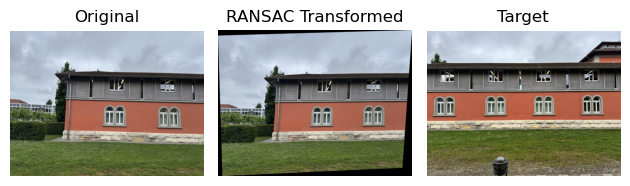

In [15]:
matched_indices = matches.nonzero()[0]
img1_matched_points = img1_location_list[matched_indices, :2]
img2_matched_points = img2_location_list[matches[matched_indices], :2]

H_ransac, inliers = ransac(img1_matched_points, img2_matched_points, max_inlier_distance=5.0, num_iterations=1000)

H_rect, height, width = rectify_homography(H_ransac, images[0])
warped_img_ransac = cv2.warpPerspective(images[0], H_rect, (width, height))

display_images(
    [images[0], warped_img_ransac, images[1]],
               ["Original", "RANSAC Transformed", "Target"])

5518 key points detected.
3433 key points detected.


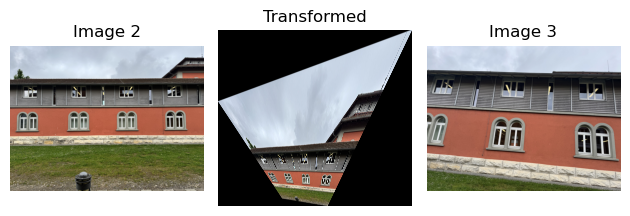

3433 key points detected.
5644 key points detected.


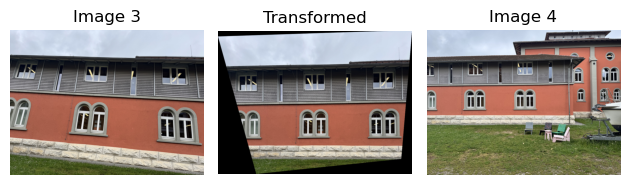

In [16]:
for i in range(1, len(images) - 1):
    img1_grey = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
    img1_location_list, img1_descriptor_list = sift.detect_and_compute(img1_grey)

    img2_grey = cv2.cvtColor(images[i+1], cv2.COLOR_BGR2GRAY)
    img2_location_list, img2_descriptor_list = sift.detect_and_compute(img2_grey)

    matches = sift.match_twosided(img1_descriptor_list, img2_descriptor_list)

    matched_indices = matches.nonzero()[0]
    img1_matched_points = img1_location_list[matched_indices, :2]
    img2_matched_points = img2_location_list[matches[matched_indices], :2]

    H_ransac, inliers = ransac(
        img1_matched_points, img2_matched_points,
        max_inlier_distance=5.0, num_iterations=1000
    )

    H_rect, height, width = rectify_homography(H_ransac, images[i])
    warped_img_ransac = cv2.warpPerspective(images[i], H_rect, (width, height))

    display_images(
        [images[i], warped_img_ransac, images[i+1]],
        [f'Image {i+1}', 'Transformed', f'Image {i+2}']
    )

9626 key points detected.
11024 key points detected.


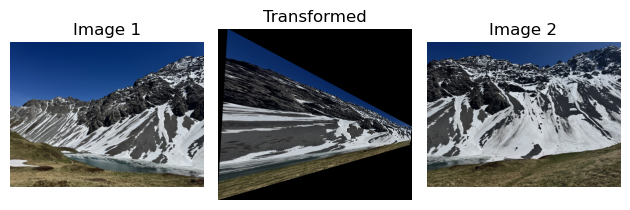

11024 key points detected.
10566 key points detected.


In [ ]:
data_dir = 'data/stiching/mountain'
image_paths = sorted(glob.glob(os.path.join(data_dir, '*.jpeg')))
images = []

for image_path in image_paths:
    images.append(imread(image_path))

for i in range(len(images) - 1):
    img1_grey = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
    img1_location_list, img1_descriptor_list = sift.detect_and_compute(img1_grey)

    img2_grey = cv2.cvtColor(images[i+1], cv2.COLOR_BGR2GRAY)
    img2_location_list, img2_descriptor_list = sift.detect_and_compute(img2_grey)

    matches = sift.match_twosided(img1_descriptor_list, img2_descriptor_list)

    matched_indices = matches.nonzero()[0]
    img1_matched_points = img1_location_list[matched_indices, :2]
    img2_matched_points = img2_location_list[matches[matched_indices], :2]

    H_ransac, inliers = ransac(
        img1_matched_points, img2_matched_points,
        max_inlier_distance=5.0, num_iterations=1000
    )

    H_rect, height, width = rectify_homography(H_ransac, images[i])
    warped_img_ransac = cv2.warpPerspective(images[i+1], H_rect, (width, height))

    display_images(
        [images[i], warped_img_ransac, images[i+1]],
        [f'Image {i+1}', 'Transformed', f'Image {i+2}']
    )